# IBM - Coursera Data Science Capstone Project - Car accident severity 

## Table of contents
* [1. Context and Understanding of the Problem](#problem)
* [2. The Data Collected](#data)
* [3. Methodology](#methodology)
    * [3.1. Data Collection](#data-collection)
    * [3.2. Data Exploration and Preparation](#data-exploration)
    * [3.3. Modeling](#modeling)
* [4. Results](#results)
* [5. Discussion](#discussion)
* [6. Conclusion](#conclusion)

# 1. Context and Understanding of the Problem <a name="problem"></a>

Although decreasing over the past 20 years, road / car accidents still represent a very significant number of deaths and injuries in most countries, impacting not only human lives but also national economies (heath care, infrastructure, productivity...). Worldwide, approximately 1.35 million people die each year as a result of road traffic crashes. Road traffic injuries are the leading cause of death for children and young adults aged 5-29 years. And Road traffic crashes cost most countries 3% of their gross domestic product (source: [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/road-traffic-injuries)).

In 2019, nearly 3,500 people died on the roads of mainland France or overseas. The cost linked to personal accidents represent €39.7 billions, and overall cost of road accidents is estimated at €50.9 Billions representing 2.2% of the country GDP (source: [French road safety observatory](https://www.onisr.securite-routiere.gouv.fr/en/road-safety-performance/annual-road-safety-reports/2019-road-safety-annual-report)).

Thanks to the accident data provided by the French Government, our goal is to **build a model that will allow to predict the severity of an accident in France**.

This information can be useful: 
- For government or local institutions to prevent such accidents through a variety of measures: prevention, communication, renovation or enhancements of infrastructure...
- For hospitals or healthcare services to anticipate the needs for medical services for certain periods of time and locations. Or when they are about to handle accident injuries and receive the accident detail from the emergency services.

# 2. The data collected and how to build this model <a name="data"></a>

For this project, we will use a **dataset provided by the French Government on personal accident in France from 2005 to 2018**. This dataset can be downloaded on the portal dedicated to French public data sharing: [data.gouv.fr](https://www.data.gouv.fr/en/datasets/base-de-donnees-accidents-corporels-de-la-circulation/). It actually includes accidents including any king of vehicles (cars, trucks, motocybless, bus, bike, scooter, train...) and any kind of user involved (driver, passenger, pedestrian).

This dataset provided for a period of 13 years (2005-2018) details regarding the accident, the location and environment, the user(s) and vehicule. It is actually shared in 4 files provided for each year:
- A file for the accident details: date and time, address / geolocation, lighting condition, type of intersection, weather conditions, type of accident,..
- A file for the location details: road type, traffic type, number of traffic lane, reserved lane, road inclination, surface condition...
- A file for the user details: type, location in the vehicle, severity of accident, sex, birth year, safety equipment, reason for traveling,...
- A file for the vehicle details: type, number of person in the vehicle, fixed of mobile obstacle collision, collision area, manœuvre type,...

We will use as label for our prediction model the **severity of the accident** that is provided at the user level. This severity is provided on a scale of 4, that we may review / simplify. It is to be noted that there hase been a change of qualification regarding the classification of accident severity in 2018, which makes the corresponding data not comparable with previous years. Out of precaution, we will remove the data for 2018.

We will also add the information of holiday as well as the distinction between weekdays and weekends.

During the exploratory data analysis, we will analyse the missing information, clean the data and select the features we want to keep for our model(s).

We will then build our model(s), evaluate them and select the one(s) that seem the most appropriate. 
Last we will discuss the outcome and limits of our approach and present some ways of improvements.

# 3. Methodology <a name="methodology"></a>



## 3.1. Data Collection <a name="data-collection"></a>
Since the data is split in 4 files per year, we need to build a function that will concatenate for each kind of file (accident, vehicle, location and user) the different years.

In [1]:
# Import librairies
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
mpl.style.use('ggplot') # optional: for ggplot-like style
import seaborn as sns


# Set a function to concatenate all the files for the different years
def concat_data(year_begin,year_end,file_type):
    df = pd.read_csv(f'Datasets/{year_begin}/{file_type}_{year_begin}.csv',engine='python')
    print(f'{year_begin} imported')
    year_range = range(year_begin+1,year_end+1)
    for year in year_range:
        df_add = pd.read_csv(f'Datasets/{year}/{file_type}_{year}.csv',engine='python')
        df = pd.concat([df,df_add],axis=0)
        print(f'{year} imported')
    return df

### 3.1.1.  Import Accident Data

In [2]:
# Concatenate all the accident files for the selected years
accident_data = concat_data(2005,2017,'caracteristiques')

2005 imported
2006 imported
2007 imported
2008 imported
2009 imported
2010 imported
2011 imported
2012 imported
2013 imported
2014 imported
2015 imported
2016 imported
2017 imported


In [3]:
# Rename Columns
accident_data.rename(columns={'Num_Acc':'acc_ID','an':'year','mois':'month','jour':'day','lum':'lighting','com':'city','agg':'area','int':'intersection','atm':'weather','col':'collision','adr':'address','dep':'county'},inplace=True)
accident_data.head()

,acc_ID,year,month,day,hrmn,lighting,area,intersection,weather,collision,city,address,gps,lat,long,county
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,11.0,CD41B,M,5051500.0,294400,590
1,200500000002,5,1,21,1600,1,2,1,1.0,1.0,51.0,rue de Lille,M,5053700.0,280200,590
2,200500000003,5,1,21,1845,3,1,1,2.0,1.0,51.0,NaN,M,5054600.0,280000,590
3,200500000004,5,1,4,1615,1,1,1,1.0,5.0,82.0,NaN,M,5098700.0,240800,590
4,200500000005,5,1,10,1945,3,1,1,3.0,6.0,478.0,NaN,M,5096400.0,247500,590


See the Column Detail.txt file for more information on the column details.

In [4]:
# Display the dataframe details
print(accident_data.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900686 entries, 0 to 60700
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   acc_ID        900686 non-null  int64  
 1   year          900686 non-null  int64  
 2   month         900686 non-null  int64  
 3   day           900686 non-null  int64  
 4   hrmn          900686 non-null  int64  
 5   lighting      900686 non-null  int64  
 6   area          900686 non-null  int64  
 7   intersection  900686 non-null  int64  
 8   weather       900618 non-null  float64
 9   collision     900669 non-null  float64
 10  city          900684 non-null  float64
 11  address       759322 non-null  object 
 12  gps           422319 non-null  object 
 13  lat           415441 non-null  float64
 14  long          415437 non-null  object 
 15  county        900686 non-null  int64  
dtypes: float64(4), int64(9), object(3)
memory usage: 116.8+ MB
None


### 3.1.2. Import User Data

In [5]:
# Concatenate all the user files for the selected years
user_data = concat_data(2005,2017,'usagers')

2005 imported
2006 imported
2007 imported
2008 imported
2009 imported
2010 imported
2011 imported
2012 imported
2013 imported
2014 imported
2015 imported
2016 imported
2017 imported


In [6]:
# Rename Columns
user_data.rename(columns={'Num_Acc':'acc_ID','place':'place_in_veh','catu':'user_type','grav':'severity','sexe':'sex','trajet':'purpose','secu':'security','locp':'pedestrian_loc','actp':'pedestrian_action','etatp':'pedestrian_situation','an_nais':'birth_year','num_veh':'veh_ID'},inplace=True)
user_data.head()

,acc_ID,place_in_veh,user_type,severity,sex,purpose,security,pedestrian_loc,pedestrian_action,pedestrian_situation,birth_year,veh_ID
0,200500000001,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0,A01
1,200500000001,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0,B02
2,200500000001,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0,B02
3,200500000001,4.0,2,1,1,0.0,31.0,0.0,0.0,0.0,2004.0,B02
4,200500000001,5.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1998.0,B02


See the Column Detail.txt file for more information on the column details.

In [7]:
# Print the information of the dataframe
print(user_data.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012026 entries, 0 to 136020
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   acc_ID                2012026 non-null  int64  
 1   place_in_veh          1899858 non-null  float64
 2   user_type             2012026 non-null  int64  
 3   severity              2012026 non-null  int64  
 4   sex                   2012026 non-null  int64  
 5   purpose               2011646 non-null  float64
 6   security              1959618 non-null  float64
 7   pedestrian_loc        2010316 non-null  float64
 8   pedestrian_action     2010210 non-null  float64
 9   pedestrian_situation  2010254 non-null  float64
 10  birth_year            2009638 non-null  float64
 11  veh_ID                2012026 non-null  object 
dtypes: float64(7), int64(4), object(1)
memory usage: 199.6+ MB
None


### 3.1.2. Import Vehicle Data

In [8]:
vehicle_data = concat_data(2005,2017,'vehicules')

2005 imported
2006 imported
2007 imported
2008 imported
2009 imported
2010 imported
2011 imported
2012 imported
2013 imported
2014 imported
2015 imported
2016 imported
2017 imported


In [9]:
# Rename Columns
vehicle_data.rename(columns={'Num_Acc':'acc_ID','senc':'flow_dir','catv':'veh_cat','occutc':'user_num','obs':'fixed_obst','obsm':'mobile_obst','choc':'impact','manv':'manoeuvre','num_veh':'veh_ID'},inplace=True)
vehicle_data.head()

,acc_ID,flow_dir,veh_cat,user_num,fixed_obst,mobile_obst,impact,manoeuvre,veh_ID
0,200500000001,0.0,7,0,0.0,2.0,1.0,1.0,A01
1,200500000001,0.0,7,0,0.0,2.0,8.0,10.0,B02
2,200500000002,0.0,7,0,0.0,2.0,7.0,16.0,A01
3,200500000002,0.0,2,0,0.0,2.0,1.0,1.0,B02
4,200500000003,0.0,2,0,0.0,2.0,1.0,1.0,A01


See the Column Detail.txt file for more information on the column details.

In [10]:
vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536935 entries, 0 to 103545
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   acc_ID       1536935 non-null  int64  
 1   flow_dir     1536795 non-null  float64
 2   veh_cat      1536935 non-null  int64  
 3   user_num     1536935 non-null  int64  
 4   fixed_obst   1536118 non-null  float64
 5   mobile_obst  1536292 non-null  float64
 6   impact       1536671 non-null  float64
 7   manoeuvre    1536599 non-null  float64
 8   veh_ID       1536935 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 117.3+ MB


### 3.1.4. Import Location Data

In [11]:
location_data = concat_data(2005,2017,'lieux')

2005 imported
2006 imported
2007 imported
2008 imported
2009 imported
2010 imported
2011 imported
2012 imported
2013 imported
2014 imported
2015 imported
2016 imported
2017 imported


In [12]:
# Rename Columns
location_data.rename(columns={'Num_Acc':'acc_ID','catr':'road_cat','voie':'road_id','v1':'road_det1','v2':'road_det2','circ':'road_type','nbv':'lane_numb','pr':'road_marker','pr1':'rm_dist','vosp':'spec_lane','prof':'road_grad','plan':'road_shape','lartpc':'med_strip','larrout':'road_width','surf':'road_surf','situ':'loc','env1':'school_prox'},inplace=True)
location_data.head()

,acc_ID,road_cat,road_id,road_det1,road_det2,road_type,lane_numb,road_marker,rm_dist,spec_lane,road_grad,road_shape,med_strip,road_width,road_surf,infra,loc,school_prox
0,200500000001,3.0,41,0.0,B,2.0,2.0,1.0,430.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0
1,200500000002,2.0,41,0.0,NaN,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,100.0,1.0,0.0,5.0,0.0
2,200500000003,2.0,41,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,5.0,0.0
3,200500000004,3.0,916,0.0,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,200500000005,3.0,110,0.0,NaN,2.0,2.0,24.0,630.0,0.0,1.0,3.0,0.0,59.0,2.0,0.0,3.0,0.0


See the Column Detail.txt file for more information on the column details.

In [13]:
location_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900686 entries, 0 to 60700
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   acc_ID       900686 non-null  int64  
 1   road_cat     900685 non-null  float64
 2   road_id      833668 non-null  object 
 3   road_det1    333224 non-null  float64
 4   road_det2    36647 non-null   object 
 5   road_type    899517 non-null  float64
 6   lane_numb    898462 non-null  float64
 7   road_marker  440977 non-null  float64
 8   rm_dist      439431 non-null  float64
 9   spec_lane    898450 non-null  float64
 10  road_grad    899176 non-null  float64
 11  road_shape   898825 non-null  float64
 12  med_strip    888978 non-null  float64
 13  road_width   890387 non-null  float64
 14  road_surf    899204 non-null  float64
 15  infra        895744 non-null  float64
 16  loc          896210 non-null  float64
 17  school_prox  895705 non-null  float64
dtypes: float64(15), int64(1),

### 3.1.5. Merge the 4 data files

We have the following sets to merge:

|| acc_ID| veh_ID|
| :------------- | :----------: | -----------: |
|accident_data|900,686||
|user_data|2,012,026|2,012,026|
|vehicle_data|1,536,935|1,536,935|
|location_data|900,686||

In [14]:
# Merge the accident and location data
acc_loc = accident_data.merge(location_data,how='outer',on='acc_ID')

# Print the information of the merged file
acc_loc.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900686 entries, 0 to 900685
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   acc_ID        900686 non-null  int64  
 1   year          900686 non-null  int64  
 2   month         900686 non-null  int64  
 3   day           900686 non-null  int64  
 4   hrmn          900686 non-null  int64  
 5   lighting      900686 non-null  int64  
 6   area          900686 non-null  int64  
 7   intersection  900686 non-null  int64  
 8   weather       900618 non-null  float64
 9   collision     900669 non-null  float64
 10  city          900684 non-null  float64
 11  address       759322 non-null  object 
 12  gps           422319 non-null  object 
 13  lat           415441 non-null  float64
 14  long          415437 non-null  object 
 15  county        900686 non-null  int64  
 16  road_cat      900685 non-null  float64
 17  road_id       833668 non-null  object 
 18  road

In [15]:
# Merge the user and vehicle data
user_veh = user_data.merge(vehicle_data,how='outer',on=['acc_ID','veh_ID'])

# Print the information of the merged file
user_veh.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035270 entries, 0 to 2035269
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   acc_ID                2035270 non-null  int64  
 1   place_in_veh          1899858 non-null  float64
 2   user_type             2012026 non-null  float64
 3   severity              2012026 non-null  float64
 4   sex                   2012026 non-null  float64
 5   purpose               2011646 non-null  float64
 6   security              1959618 non-null  float64
 7   pedestrian_loc        2010316 non-null  float64
 8   pedestrian_action     2010210 non-null  float64
 9   pedestrian_situation  2010254 non-null  float64
 10  birth_year            2009638 non-null  float64
 11  veh_ID                2035270 non-null  object 
 12  flow_dir              2035072 non-null  float64
 13  veh_cat               2035248 non-null  float64
 14  user_num              2035248 non-

We can notice that we have several rows with missing information for the severity

In [16]:
# Print the rows with no information regarding severity
user_veh[user_veh.severity.isnull()]

,acc_ID,place_in_veh,user_type,severity,sex,purpose,security,pedestrian_loc,pedestrian_action,pedestrian_situation,birth_year,veh_ID,flow_dir,veh_cat,user_num,fixed_obst,mobile_obst,impact,manoeuvre
2012026,200500000170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B02,1.0,10.0,0.0,0.0,2.0,2.0,2.0
2012027,200500000471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A01,1.0,7.0,0.0,0.0,2.0,2.0,1.0
2012028,200500000524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B02,1.0,7.0,0.0,0.0,2.0,0.0,13.0
2012029,200500000815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A01,1.0,7.0,0.0,0.0,0.0,0.0,15.0
2012030,200500000832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B02,1.0,7.0,0.0,0.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035265,201700060560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B01,2.0,30.0,0.0,0.0,0.0,0.0,0.0
2035266,201700060589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B01,1.0,7.0,0.0,0.0,2.0,8.0,9.0
2035267,201700060612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A01,2.0,7.0,0.0,14.0,2.0,4.0,9.0
2035268,201700060642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B01,2.0,31.0,0.0,0.0,2.0,8.0,9.0


It seems that we have more than 23,000 rows with information regarding a vehicle but no information regarding any corresponding user. Since we need this information for our model and considering this missing information do no represesent a significant amount of our dataser (around 1%) we can exclude them from our data collection. We will thus perform a "left" merge keeping only the rows for which we have the user and severity detail.

In [17]:
# Merge the user and vehicle data
user_veh = user_data.merge(vehicle_data,how='left',on=['acc_ID','veh_ID'])

# Print the information of the merged file
user_veh.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012026 entries, 0 to 2012025
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   acc_ID                2012026 non-null  int64  
 1   place_in_veh          1899858 non-null  float64
 2   user_type             2012026 non-null  int64  
 3   severity              2012026 non-null  int64  
 4   sex                   2012026 non-null  int64  
 5   purpose               2011646 non-null  float64
 6   security              1959618 non-null  float64
 7   pedestrian_loc        2010316 non-null  float64
 8   pedestrian_action     2010210 non-null  float64
 9   pedestrian_situation  2010254 non-null  float64
 10  birth_year            2009638 non-null  float64
 11  veh_ID                2012026 non-null  object 
 12  flow_dir              2011849 non-null  float64
 13  veh_cat               2012004 non-null  float64
 14  user_num              2012004 non-

In [18]:
# Merge the data tables together
merged_data = user_veh.merge(acc_loc,how='outer',on=['acc_ID'])
merged_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012026 entries, 0 to 2012025
Data columns (total 51 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   acc_ID                2012026 non-null  int64  
 1   place_in_veh          1899858 non-null  float64
 2   user_type             2012026 non-null  int64  
 3   severity              2012026 non-null  int64  
 4   sex                   2012026 non-null  int64  
 5   purpose               2011646 non-null  float64
 6   security              1959618 non-null  float64
 7   pedestrian_loc        2010316 non-null  float64
 8   pedestrian_action     2010210 non-null  float64
 9   pedestrian_situation  2010254 non-null  float64
 10  birth_year            2009638 non-null  float64
 11  veh_ID                2012026 non-null  object 
 12  flow_dir              2011849 non-null  float64
 13  veh_cat               2012004 non-null  float64
 14  user_num              2012004 non-

## 3.2. Data Exploration and Preparation <a name="data-exploration"></a>

### 3.2.1. Check and remove duplicate rows

When we look for the duplicated rows, we can find 2505 users with the same accident details.

In [19]:
dupl_rows = merged_data[merged_data.duplicated()].copy()
len(dupl_rows)

2505

However, when we look at the detail of the place in vehicle, we realize that more than 58% of them correspond to people involved in an accident while they were in a public transport (bus, coach, train, tramway).
If we look at the data description, we see that we can have people being assigned to the same place in vehicle for public transport ('Transport en commun'), while this is not possible for car ('voiture') or moto / side-car.
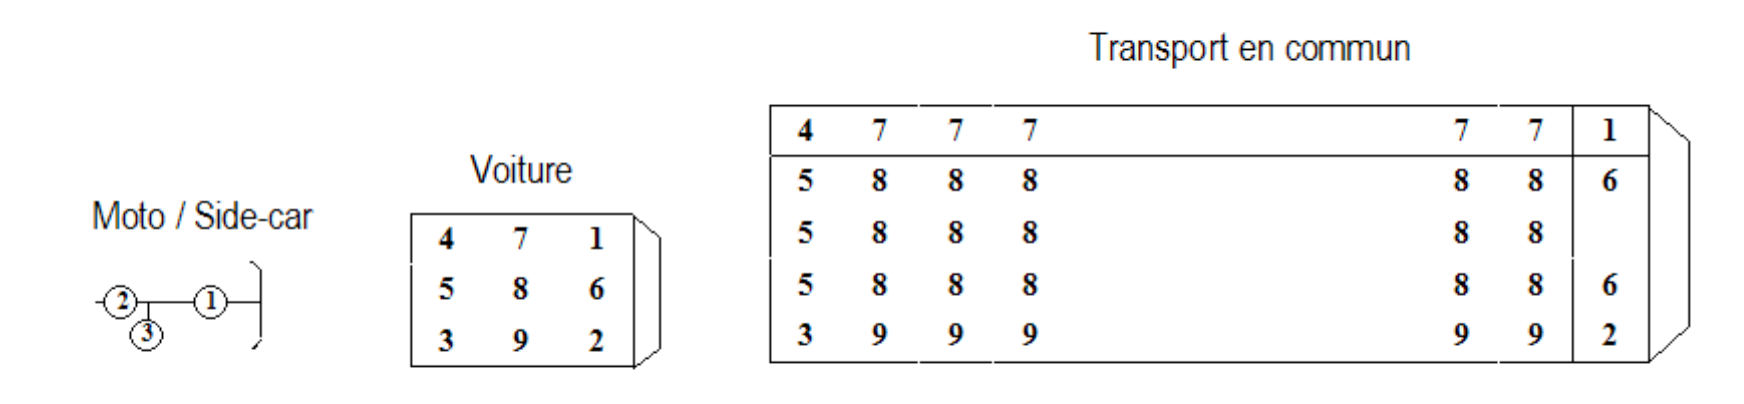

In [20]:
# Calculate the percentage of duplicated rows corresponding to user involved in an accident 
# with a vehicule category corresponding to a bus, a coach, a train or a tramway.
dupl_rows.veh_cat[dupl_rows.veh_cat.isin([18,19,37,38,39,40])].value_counts()/len(dupl_rows)*100

38.0    40.199601
37.0    10.698603
18.0     8.742515
39.0     0.638723
40.0     0.079840
Name: veh_cat, dtype: float64

Thus, we can consider that these rows for this vehicle categories are not actual duplicates and that we can keep them.

In [21]:
dupl_rows.drop(index = dupl_rows[dupl_rows.veh_cat.isin([18,19,37,38,39,40])].index, inplace=True)
len(dupl_rows)

993

Then, if we look at the user_type, we can see that there are 509 users classified as pedestrians or rollerblade / scooter users (user_type 3 and 4).

In [22]:
dupl_rows.user_type.value_counts()

3    506
2    484
4      3
Name: user_type, dtype: int64

And we can see that these users have been assigned with a place_in_veh of 0 meaning they were not in the vehicle and thus correctly identified as pedestrians. Since we can have several pedestrians reported with the same accident details, these are not duplicated neither and we can exclude them from our duplicated rows.

In [23]:
dupl_rows.drop(index = dupl_rows[(dupl_rows.user_type.isin([3,4]))].index, inplace=True)
len(dupl_rows)

484

As for the remaining duplicates, we will remove them from our data base.

In [24]:
merged_data.drop(index = dupl_rows.index,inplace=True)
len(merged_data)

2011542

### 3.2.2. Check and Update Missing Values

We will first focus on attributes for which we miss more than 2% of the data, considering that we should be able to remove the missing rows without impacting significantly our model for the other attributes with percentage of missing data <=2%.

In [25]:
# Calculate the percentage of na values
def per_na(df,perc):
    na_perc = {}
    for c in df.columns:
        na_perc[c] = round(sum(df[c].isna())/len(df)*100,2)
    df_na_perc = pd.DataFrame.from_dict(na_perc,orient='index',columns=['na_perc']).sort_values('na_perc',ascending=False)
    return df_na_perc[df_na_perc['na_perc']>perc]

# Display the information with a percentage of missing data > 2
per_na(merged_data,2)

,na_perc
road_det2,95.74
road_det1,62.73
long,52.78
lat,52.78
gps,51.97
rm_dist,49.24
road_marker,49.08
address,16.85
road_id,6.99
place_in_veh,5.58


The 7 first attributes of this list that have missing information for almost 50% or more of the data set (road details, gps code, longitude, latitude, road marker information...) along with the address (almost 17% of missing information) are also information that will be difficult to use with this format for our model. 

When we try to find if the information is available within the same accident number, it seems this information is not available neither.

In [27]:
# Set a function allowing to find for missing values of an attribute for a user if this information is available
# for another user involved in the same accident
def check_dataset(attribute,limit):
    info_acc = []
    focus = merged_data[merged_data[attribute].isnull()]
    if len(list(focus['acc_ID'].unique())) > limit:
        sample = random.sample(list(focus['acc_ID'].unique()),limit)
    else:
        sample = list(focus['acc_ID'].unique())
    for a in sample:
        acc_data = merged_data[merged_data.acc_ID == a][attribute]
        if acc_data.notna().any() == True:
            info_acc.append(a)
    if len(info_acc)>0:
        display(merged_data[merged_data['acc_ID'].isin(info_acc)].sort_values('acc_ID'))
    print(f'There are at least {len(info_acc)} accident IDs with the missing information available for another user / vehicle.')
    return info_acc

# Check if the missing address for one user / vehicle row can be found for other user / vehicle for the same accident ID
# We can set a limit of maximum number of accidents to review / test for performance purpose
address_check = check_dataset('address',10000)

There are at least 0 accident IDs with the missing information available for another user / vehicle.


In [28]:
long_check = check_dataset('long',10000)

There are at least 0 accident IDs with the missing information available for another user / vehicle.


Altough the lack of GPS information reduce over time, it still remain significant enough not to only focus on the last 5 or 10 years of the dataset.

In [29]:
missing_gds = merged_data[merged_data['long'].isnull()]['year'].value_counts()
acc_per_year = merged_data.groupby('year').acc_ID.count()
missing_gds_perc = missing_gds / acc_per_year 
missing_gds_perc 

5     0.674864
6     0.687881
7     0.703870
8     0.703159
9     0.535763
10    0.532897
11    0.534093
12    0.539352
13    0.506703
14    0.478584
15    0.358152
16    0.215337
17    0.132532
dtype: float64

As a conclusion for the location, we should drop the gps attributes and use the city code, the county code and road_id to manage the location.

In [30]:
# Check if we can find the missing road_id on other user / vehicle involved in the same accident
road_id_check = check_dataset('road_id',10000)

There are at least 0 accident IDs with the missing information available for another user / vehicle.


We can try to replace that information with another one also linked to the location.
Since we have similar city code and road id, we can not use the city code to replace the road id.

In [31]:
# Computes the number of similar code for city code and road_id
len(set(merged_data['city'].unique()).intersection(merged_data['road_id'].unique()))

897

To ensure we will have unique identifier for the missing road_id that will be linked to the closest location information we can have, we will use a combination of city and county codes to replace the missing road_id.

In [32]:
# Identify the nan value to replace
nan_index = merged_data[merged_data['road_id'].isnull()].index
merged_data.loc[nan_index,'road_id']

4922       NaN
7081       NaN
7082       NaN
7083       NaN
7084       NaN
          ... 
2012015    NaN
2012016    NaN
2012017    NaN
2012018    NaN
2012019    NaN
Name: road_id, Length: 140619, dtype: object

In [33]:
# Replace the nan values with the city code * county code to ensure these new road_ids will be different from any existing ones.
merged_data.loc[merged_data['road_id'].isnull(),'road_id'] = merged_data['city']*merged_data['county']

# Display the updated road_id to check
merged_data.loc[nan_index,'road_id']

4922        50760
7081         2100
7082        72900
7083        72900
7084         2100
            ...  
2012015    596336
2012016    596336
2012017    596336
2012018    596336
2012019    596336
Name: road_id, Length: 140619, dtype: object

When we look at the detail of the remaining values of the column road_id, we actually realize that we have values stored as strings with letters.

In [34]:
rid_list=[]
for rid in merged_data.road_id:
    if type(rid)== str:
        if rid.upper().isupper()==True:
            rid_list.append(rid)
set(rid_list)

{'000D1',
 '000D9',
 '000d4',
 '0063E',
 '009E1',
 '00CR7',
 '00D04',
 '00D14',
 '00D18',
 '00D25',
 '00D32',
 '00D42',
 '00D49',
 '00D51',
 '00D72',
 '00D75',
 '00m18',
 '0CD16',
 '0CD30',
 '0D.32',
 '0D118',
 '0D149',
 '0D504',
 '0D751',
 '0D810',
 '0D817',
 '0D952',
 '0D996',
 '0SANS',
 '103E2',
 'CD 21',
 'CD342',
 'D2204',
 'M6098',
 'RD386',
 'RD603',
 'RD888',
 'd6007'}

These letters seem to correspond to the road category that should have been removed. In order to have a column with only one type (ideally float to train our model later), we are going to remove these letters and convert the string values to float.

In [35]:
# Remove all the letters and characters in the string values of the column road_id
import re
merged_data['road_id'] = merged_data.road_id.apply(lambda x: x if not isinstance(x, str) else float(re.sub('\D', '', x)))

In [36]:
# Check that we do not have anymore string in the road_id columne
merged_data.loc[merged_data.road_id.apply(lambda x: isinstance(x, str))]

,acc_ID,place_in_veh,user_type,severity,sex,purpose,security,pedestrian_loc,pedestrian_action,pedestrian_situation,birth_year,veh_ID,flow_dir,veh_cat,user_num,fixed_obst,mobile_obst,impact,manoeuvre,year,month,day,hrmn,lighting,area,intersection,weather,collision,city,address,gps,lat,long,county,road_cat,road_id,road_det1,road_det2,road_type,lane_numb,road_marker,rm_dist,spec_lane,road_grad,road_shape,med_strip,road_width,road_surf,infra,loc,school_prox


Then, if we look at the attribute 'place_in_veh', we realize that we do not have any information regarding the place in the vehicle for user that are classified as 'pedestrian' and 'Pedestrian in rollerblade or scooter', which makes sense.

In [37]:
merged_data[merged_data['place_in_veh'].isnull()].user_type.value_counts()

3    109781
4      2387
Name: user_type, dtype: int64

We can thus replace the nan values by a 0 value which correspond to this category of user.

In [38]:
merged_data[merged_data['user_type'].isin([3,4])].place_in_veh.value_counts()

0.0    58550
Name: place_in_veh, dtype: int64

In [39]:
merged_data['place_in_veh'].fillna(0,inplace=True)

For the last attribute to check 'security', we can see that the information is missing for the pedestrians (user_type 3 and 4), which also makes sense.

In [40]:
merged_data[merged_data['security'].isnull()].user_type.value_counts()

3    50384
1     1186
4      605
2      232
Name: user_type, dtype: int64

As for the 'place_in_veh', we are going to replace these na values by '0', which is already use to idenfify users without any security equipements.

In [41]:
# Identify the nan value to replace
nan_index = merged_data[(merged_data['security'].isnull())&(merged_data['user_type'].isin([3,4]))].index

# Replace the nan values with 0.
merged_data.loc[nan_index,'security'] = 0 

# Check that we have only the remaining na values for this attribute
merged_data[merged_data['security'].isnull()].user_type.value_counts()

1    1186
2     232
Name: user_type, dtype: int64

Finally, we can remove all the attributes related to the location that we have decided to drop: road_det2,road_det1,long,lat,gps,rm_dist,road_marker and address. We will remove the remaining rows with na values once we will have selected our features.

In [42]:
# Remove the columns
merged_data.drop(columns=['road_det2','road_det1','long','lat','gps','rm_dist','road_marker','address'],inplace=True)

# Save the dataset
merged_data.to_csv('Datasets/Aggregated Data/merged_data.csv',index=False)

###  3.2.3. Review and simplify data

To distinguish the original data_set from the dataset we are going to select for the model we copy the dataset

In [43]:
import pandas as pd
cleaned_dataset = pd.read_csv('Datasets/Aggregated Data/merged_data.csv')

Then, we can have a first look at the distribution of the different attributes and see which one(s) we can try to simplify without potentially impacting the accuracy of our model.

[]

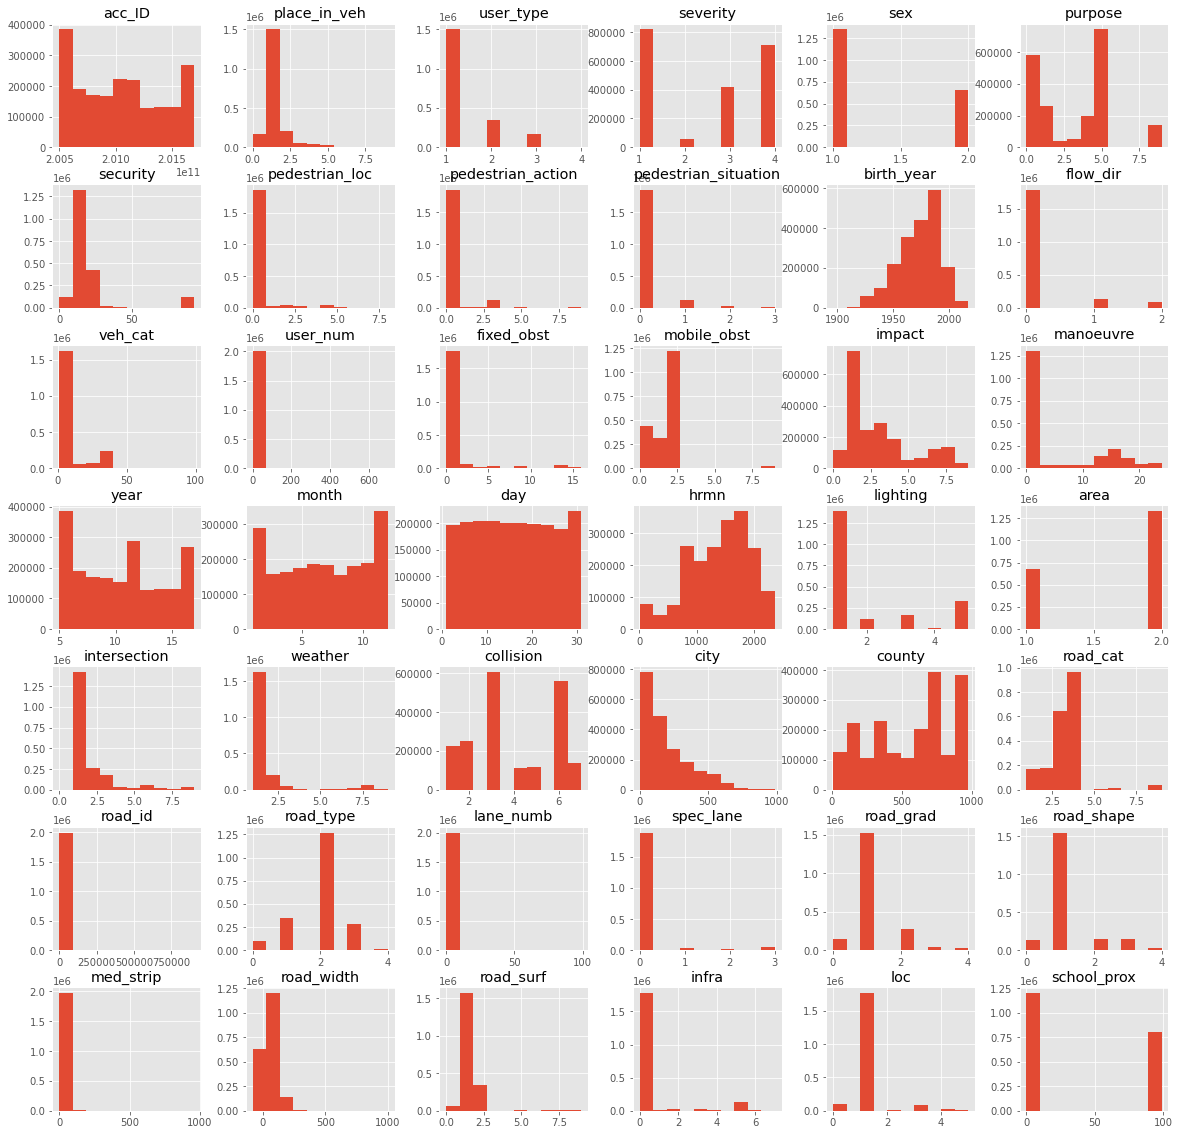

In [44]:
cleaned_dataset.hist(figsize=(20,20))
plt.plot()

I have reviewed the detail of all the attributes. However, to limit the length of this notebook, I have only detailed below the attributes that I believe we could simplify or had to remove.

#### The Target Variable Severity

As a reminder, there are 3 categories of injuries + 1 for the unarmed users.
1. Unarmed
2. Killed
3. Wounded - hospitalized
4. Light injury

[]

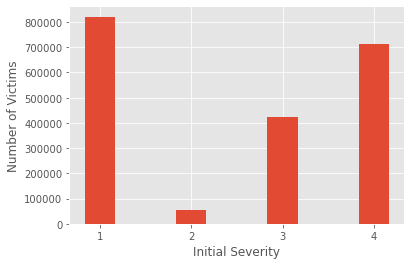

In [45]:
# Display the severity distribution
cleaned_dataset.severity.hist()
plt.xticks([1.15,2.05,2.95,3.85],[1,2,3,4])
plt.xlabel('Initial Severity')
plt.ylabel('Number of Victims')
plt.plot()

The distribution shows unbalanced labels especially for the higher severity "Killed".

In order to get a more balanced distribution, we will combine the severity 2 and 3 in a single category "Severly Injured or Killed", which leaves us with 3 levels:
1. Unarmed
2. Light Injury
3. Severly Injured or Killed

[]

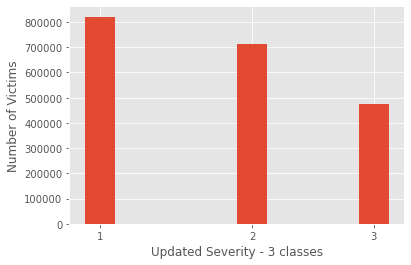

In [46]:
# Create a new column for the updated severity
cleaned_dataset['upd_sev_3']= cleaned_dataset.severity
cleaned_dataset['upd_sev_3'].replace({2:3,4:2}, inplace=True)

# Display the new severity distribution
cleaned_dataset.upd_sev_3.hist()
plt.xticks([1.1,2.1,2.9],[1,2,3])
plt.xlabel('Updated Severity - 3 classes')
plt.ylabel('Number of Victims')
plt.plot()

However, this classification shows 2 categories that could also be combined together to distinguish the lowest severity accidents from the most severe ones with:
1. Unarmed or light injury
2. Severly Injured or Killed

Although it is less balanced than the second one, this distinction should allow to be more pro-active towards the situations where we have the most severe accidents.

[]

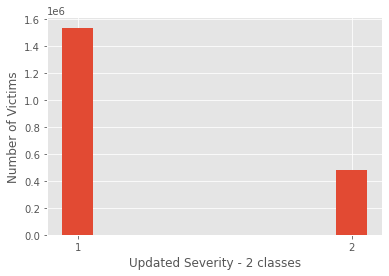

In [47]:
# Create a new column for the updated severity
cleaned_dataset['upd_sev_2']= cleaned_dataset.severity
cleaned_dataset['upd_sev_2'].replace({3:2,4:1}, inplace=True)

# Display the new severity distribution
cleaned_dataset.upd_sev_2.hist()
plt.xticks([1.05,1.95],[1,2])
plt.xlabel('Updated Severity - 2 classes')
plt.ylabel('Number of Victims')
plt.plot()

We will test our model(s) with these different severity classifications to find out which one works best in terms of predictability.

#### Simplify the attribute veh_cat
This attribute has several categories that are not used anymore and need to be reclassified with the new corresponding category.
In order to limit the number of categories, we also reclassify the categories which are linked to less than 1,000 users when they have shown similar breakdown of severity.

In [48]:
cleaned_dataset.veh_cat.replace({4:32,5:2,6:33,11:10,12:10,18:37,19:40},inplace=True)

#### Simplify the attribute security
We can notice that there are several values that are not 2 digit codes as they should be. As a reminder, the second one details the use of the safety equipment
1. Yes
2. No
3. Not determinable

Hence, we can add to all the single digit numbers a 3 at the end to make them more consistent and reduce the number of categories.

In [49]:
cleaned_dataset.security.value_counts()

11.0    1119631
21.0     365383
13.0     160144
0.0      119342
93.0     103746
23.0      39287
12.0      34711
22.0      21434
31.0      13927
92.0       7310
91.0       7175
10.0       5616
1.0        3524
41.0       2412
43.0       1904
42.0       1750
33.0        810
20.0        754
32.0        749
2.0         267
3.0         164
90.0         73
30.0          9
40.0          2
Name: security, dtype: int64

In [50]:
cleaned_dataset.security.replace({1:13,2:23,3:33,10:13,20:23,30:33,40:43,90:93},inplace=True)
cleaned_dataset.security.value_counts()

11.0    1119631
21.0     365383
13.0     169284
0.0      119342
93.0     103819
23.0      40308
12.0      34711
22.0      21434
31.0      13927
92.0       7310
91.0       7175
41.0       2412
43.0       1906
42.0       1750
33.0        983
32.0        749
Name: security, dtype: int64

#### Add the age
We are going to add the age, which might be more appropriate / better performing than the year of birth.

In [51]:
type(cleaned_dataset['year'][0])

numpy.int64

In [52]:
# Update the year column to be 'YYYY'
cleaned_dataset['year'] = cleaned_dataset['year'] + 2000

# Add a column age
cleaned_dataset['age']= cleaned_dataset['year'] - cleaned_dataset['birth_year']
cleaned_dataset[['year','birth_year','age']].head(20)

,year,birth_year,age
0,2005,1976.0,29.0
1,2005,1968.0,37.0
2,2005,1964.0,41.0
3,2005,2004.0,1.0
4,2005,1998.0,7.0
5,2005,1991.0,14.0
6,2005,1955.0,50.0
7,2005,1979.0,26.0
8,2005,1983.0,22.0
9,2005,1956.0,49.0


#### Review the flow direction
For the attribute, we can see that the information is 0 which corresponds to missing or not mentionned for almost 90% of the data. Thus, we will remove this attribute from our dataset.

In [53]:
round(cleaned_dataset.flow_dir.value_counts()/len(cleaned_dataset),2)

0.0    0.89
1.0    0.07
2.0    0.04
Name: flow_dir, dtype: float64

#### Review the number of users in vehicle
The situation is similar for this attribute with almost 99% of the data not properly updated. We will remove this attribute as well.

In [54]:
round(cleaned_dataset.user_num.value_counts()/len(cleaned_dataset),2)

0.0      0.99
1.0      0.00
2.0      0.00
10.0     0.00
3.0      0.00
         ... 
107.0    0.00
105.0    0.00
73.0     0.00
97.0     0.00
129.0    0.00
Name: user_num, Length: 118, dtype: float64

#### Review the day attribute
Based on the feature day, we can add the 2 following attributes that might help us to improve the performance of our model:
- One attribute to identify the holidays, when we might have more traffic or different traffic condition depending on the location,
- Another one to differentiate week days and weekends where the traffic conditions can also be different.

#### Add the holidays column
First, we import the holidays for France 

In [55]:
import holidays
year_range = list(range(2005,2018))
holidays_data = []
for date, name in sorted(holidays.France(years=year_range).items()):
    holidays_data.append(date)
holidays_df = pd.DataFrame(pd.to_datetime(holidays_data, format='%Y-%m-%d'),columns=['date'])
holidays_df['holiday_status'] = 1
holidays_df.tail()

,date,holiday_status
137,2017-07-14,1
138,2017-08-15,1
139,2017-11-01,1
140,2017-11-11,1
141,2017-12-25,1


In order to add this information, we need first to add a column that with the same date format as we have from the holidays file.

In [56]:
# Print the existing date columns
cleaned_dataset[['year','month','day']].head()

,year,month,day
0,2005,1,12
1,2005,1,12
2,2005,1,12
3,2005,1,12
4,2005,1,12


In [57]:
# Add a column to get the date with the format YYYY-MM-DD
cleaned_dataset['date'] = pd.to_datetime((cleaned_dataset['year'].astype('str') + '-' + cleaned_dataset['month'].astype('str') + '-' + cleaned_dataset['day'].astype('str')), format='%Y-%m-%d')
cleaned_dataset[['date']].head()

,date
0,2005-01-12
1,2005-01-12
2,2005-01-12
3,2005-01-12
4,2005-01-12


In [58]:
# Merge with the holidays table to add the holiday status
cleaned_dataset = cleaned_dataset.merge(holidays_df, on='date', how='left')
cleaned_dataset.holiday_status.fillna(0, inplace=True)
cleaned_dataset.head()

,acc_ID,place_in_veh,user_type,severity,sex,purpose,security,pedestrian_loc,pedestrian_action,pedestrian_situation,birth_year,veh_ID,flow_dir,veh_cat,user_num,fixed_obst,mobile_obst,impact,manoeuvre,year,month,day,hrmn,lighting,area,intersection,weather,collision,city,county,road_cat,road_id,road_type,lane_numb,spec_lane,road_grad,road_shape,med_strip,road_width,road_surf,infra,loc,school_prox,upd_sev_3,upd_sev_2,age,date,holiday_status
0,200500000001,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0,A01,0.0,7.0,0.0,0.0,2.0,1.0,1.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,2,1,29.0,2005-01-12,0.0
1,200500000001,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,3,2,37.0,2005-01-12,0.0
2,200500000001,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,41.0,2005-01-12,0.0
3,200500000001,4.0,2,1,1,0.0,31.0,0.0,0.0,0.0,2004.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,1.0,2005-01-12,0.0
4,200500000001,5.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1998.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,7.0,2005-01-12,0.0


In [59]:
# Check that the holidays have been correctly added
sum(sorted(list(cleaned_dataset[cleaned_dataset.holiday_status==1].date.unique()))!=holidays_df.date)

0

#### Add the day of the week and weekend status columns

We are going to add a column representing the day of the week and another one for the status of the weekend (0 for days of the week from Monday to Thursday and 1 for Friday to Sunday)

In [60]:
import datetime 
#merged_data = merged_data
# Add a column for the day of the week
cleaned_dataset['day_week'] = [x.weekday() for x in cleaned_dataset['date']]
# Add a column for the weekend status
cleaned_dataset['weekend_status'] = cleaned_dataset['day_week'].apply(lambda x: 1 if x in [5,6,7] else 0)

cleaned_dataset.head()

,acc_ID,place_in_veh,user_type,severity,sex,purpose,security,pedestrian_loc,pedestrian_action,pedestrian_situation,birth_year,veh_ID,flow_dir,veh_cat,user_num,fixed_obst,mobile_obst,impact,manoeuvre,year,month,day,hrmn,lighting,area,intersection,weather,collision,city,county,road_cat,road_id,road_type,lane_numb,spec_lane,road_grad,road_shape,med_strip,road_width,road_surf,infra,loc,school_prox,upd_sev_3,upd_sev_2,age,date,holiday_status,day_week,weekend_status
0,200500000001,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0,A01,0.0,7.0,0.0,0.0,2.0,1.0,1.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,2,1,29.0,2005-01-12,0.0,2,0
1,200500000001,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,3,2,37.0,2005-01-12,0.0,2,0
2,200500000001,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,41.0,2005-01-12,0.0,2,0
3,200500000001,4.0,2,1,1,0.0,31.0,0.0,0.0,0.0,2004.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,1.0,2005-01-12,0.0,2,0
4,200500000001,5.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1998.0,B02,0.0,7.0,0.0,0.0,2.0,8.0,10.0,2005,1,12,1900,3,2,1,1.0,3.0,11.0,590,3.0,41.0,2.0,2.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,1,1,7.0,2005-01-12,0.0,2,0


In [61]:
# Check that week days of value 5, 6 or 7 are correctly identified as weekend days
len(cleaned_dataset[cleaned_dataset['weekend_status']==1])==len(cleaned_dataset[(cleaned_dataset['day_week']==5)|(cleaned_dataset['day_week']==6)|(cleaned_dataset['day_week']==7)])

True

#### Review the hrmn attribute
This information is stored with the format hhmm which makes a high number of occurences.

In [62]:
# Display the number of different occurences for the time of the accident
cleaned_dataset.hrmn.nunique()

1439

We can try to improve that by classifiying the time per hour slot (for example 1845 -> 18).

In [63]:
# Add a column 'hour' that takes the hour from the 'hrmn' column
cleaned_dataset['hour'] = np.floor((cleaned_dataset['hrmn']/100))

# Check on the first 20 rows
cleaned_dataset[['hrmn','hour']].head(20)

,hrmn,hour
0,1900,19.0
1,1900,19.0
2,1900,19.0
3,1900,19.0
4,1900,19.0
5,1900,19.0
6,1600,16.0
7,1600,16.0
8,1845,18.0
9,1845,18.0


And we calso add a column to differentiate:
1. Morning - from 7 to 12
2. Afternoon - from 13 to 18
3. Evening - from 19 to 22
4. Night - from 23 to 6

In [64]:
# Add a column for the period of the day
cleaned_dataset['day_period'] = cleaned_dataset['hour'].apply(lambda x: 1 if x in range(7,13) else (2 if x in range(13,19) else (3 if x in range(19,23) else 4)))
# Check on the first 20 rows
cleaned_dataset[['hrmn','hour','day_period']].head(20)

,hrmn,hour,day_period
0,1900,19.0,3
1,1900,19.0,3
2,1900,19.0,3
3,1900,19.0,3
4,1900,19.0,3
5,1900,19.0,3
6,1600,16.0,2
7,1600,16.0,2
8,1845,18.0,2
9,1845,18.0,2


#### The lane_numb attribute
This attribute is supposed to represent the total number of traffic lanes. However, when looking at the detail, we find out that:
- There are 53 different numbers of lane going from 0 to 99,
- 11.56% have a number of lanes equal to 0, that we can consider as missing information,
- We have 99.2% of victims involved in an accident on road with less than 7 lanes.

In [65]:
# Display the number of different number of lanes
cleaned_dataset['lane_numb'].nunique()

53

In [66]:
# Display the different number of lanes
cleaned_dataset['lane_numb'].unique()

array([ 2.,  0.,  1.,  3.,  4.,  6., 25.,  5., 20.,  7.,  8., 30., 10.,
       40., 50., 12.,  9., 27., 62., 60., 16., 26., 11., 21., 24., 29.,
       54., 39., 14., 84., 13., 18., 90., 15., 36., 65., 22., 42., 17.,
       99., 31., 53., 76., 70., 86., 91., 28., 45., 52., 33., 41., 44.,
       23., nan])

[]

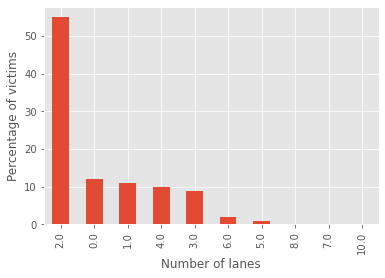

In [67]:
# Display the percentage of victims per number of lanes
round(cleaned_dataset['lane_numb'].value_counts()/len(cleaned_dataset['lane_numb'])*100).head(10).plot(kind='bar')
plt.xlabel('Number of lanes')
plt.ylabel('Percentage of victims')
plt.plot()

In [68]:
# Percentage of victims involved in an accident with a reported number of lanes = 0
round(len(cleaned_dataset['lane_numb'][cleaned_dataset['lane_numb']==0])/len(cleaned_dataset['lane_numb'])*100,2)

11.56

In [69]:
# Percentage of victims involved in an accident with a reported number of lanes < 7
round(len(cleaned_dataset['lane_numb'][cleaned_dataset['lane_numb']<7])/len(cleaned_dataset['lane_numb'])*100,3)

99.198

Based on this analysis, we can decide:
- To reclassify all the accidents having occured on a road of more than 6 lanes in a single category (lane number = 7)
- To reclassify all the accidents with a number of lanes = 0 to the most common number of lanes (2) or maybe single lane road. We can decide based on the comparison of the distribution of the severity for these 3 categories.

To compare the distribution of severity we are going to write a function that will build a cross matrix of the feature and the severity.

In [70]:
# This function will return a cross mactrix of 2 columns in values and percentage
def cross_matrix(x,y):
    cross_matrix = pd.crosstab(x,y)
    cross_matrix['total']=cross_matrix.sum(axis=1)
    for c in cross_matrix.columns[:-1]:
        cross_matrix[f'Perc. Sev. {c}']=round(cross_matrix[c]/cross_matrix['total']*100,1)
    return cross_matrix

# Set the 2 columns as number of lanes and severity
x = cleaned_dataset['lane_numb']
y = cleaned_dataset['severity']

# Compute and display the cross matrix for the 10 first lines (sorted by total)
cross_mat = cross_matrix(x,y).sort_values('total',ascending=False).head(10)
cross_mat

severity,1,2,3,4,total,Perc. Sev. 1,Perc. Sev. 2,Perc. Sev. 3,Perc. Sev. 4
lane_numb,,,,,,,,,
2.0,444471,35859,258622,376869,1115821,39.8,3.2,23.2,33.8
0.0,89306,8578,66038,68662,232584,38.4,3.7,28.4,29.5
1.0,93972,3004,39383,88457,224816,41.8,1.3,17.5,39.3
4.0,84396,2860,24133,81767,193156,43.7,1.5,12.5,42.3
3.0,75517,3089,25902,66575,171083,44.1,1.8,15.1,38.9
6.0,16830,370,3779,16288,37267,45.2,1.0,10.1,43.7
5.0,9309,237,2484,8661,20691,45.0,1.1,12.0,41.9
8.0,2664,41,540,2742,5987,44.5,0.7,9.0,45.8
7.0,994,17,216,965,2192,45.3,0.8,9.9,44.0


In [71]:
# Compare the distribution for the number of lanes 0, 1 and 2
cross_mat.loc[[0,1,2],:]

severity,1,2,3,4,total,Perc. Sev. 1,Perc. Sev. 2,Perc. Sev. 3,Perc. Sev. 4
lane_numb,,,,,,,,,
0,89306,8578,66038,68662,232584,38.4,3.7,28.4,29.5
1,93972,3004,39383,88457,224816,41.8,1.3,17.5,39.3
2,444471,35859,258622,376869,1115821,39.8,3.2,23.2,33.8


Based on this comparison, we can consider that the category number of lanes = 2 is a better choice.
Thus, we can replace the lane_numb =  0 (as well as the remaining na values that we would have reclassified with 0) by 2

In [72]:
cleaned_dataset['lane_numb'].replace({0:2},inplace=True)
cleaned_dataset['lane_numb'].fillna(2,inplace=True)

Last, we can replace all the values of num_lane >7 by 7.

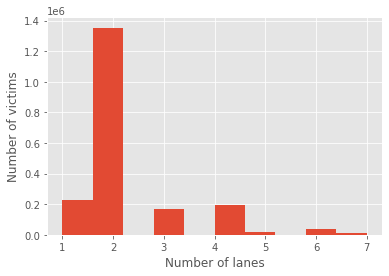

In [73]:
cleaned_dataset['lane_numb'] = cleaned_dataset['lane_numb'].apply(lambda x: x if x in list(range(0,8)) else 7)
cleaned_dataset['lane_numb'].hist()
plt.xlabel('Number of lanes')
plt.ylabel('Number of victims')
plt.show()

#### The med_strip attribute
This information represents the width of the median strip (if any). We can see that there is no median strip in almost 82% of the user accidents. Besides, the distribution is then spread on a high number of values (420). Last, the correlation and covariance with the upd_sev are very low. So not only, will it be difficult to simplify this attribute but its impact on the accuracy of the model will also be very limited. Thus, we will drop this attribute as well.

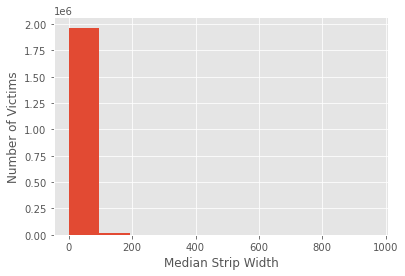

In [74]:
# Show the distribution of the median strip width
cleaned_dataset.med_strip.hist()
plt.xlabel('Median Strip Width')
plt.ylabel('Number of Victims')
plt.show()

In [75]:
# Compute the distribution of the median strip width by percentages
med_strip_detail = round(cleaned_dataset.med_strip.value_counts()/len(cleaned_dataset)*100,2)
med_strip_detail.head(10)

0.0     81.79
15.0     3.99
10.0     2.39
20.0     2.02
30.0     1.06
25.0     0.75
5.0      0.44
60.0     0.42
50.0     0.39
40.0     0.38
Name: med_strip, dtype: float64

In [76]:
# Get the number of unique values for the median strip width 
len(med_strip_detail)

420

In [77]:
# Compute the correlation between the median strip width and the severity (2 levels)
cleaned_dataset[['med_strip','upd_sev_2']].corr()

,med_strip,upd_sev_2
med_strip,1.000000,0.004207
upd_sev_2,0.004207,1.000000


In [78]:
# Compute the covariance between the median strip width and the severity (2 levels)
cleaned_dataset[['med_strip','upd_sev_2']].cov()

,med_strip,upd_sev_2
med_strip,547.692978,0.041856
upd_sev_2,0.041856,0.180827


### The purpose feature
When looking at the distribution of this feature, we can realize that there is a high proportion of 0 value, which seems to correspond to situation where no real purpose could be registered. As a reminder, the other values are:
    1. Home - work
    2. Home - school
    3. Shopping
    4. Professional use
    5. Leisure
    9. Other

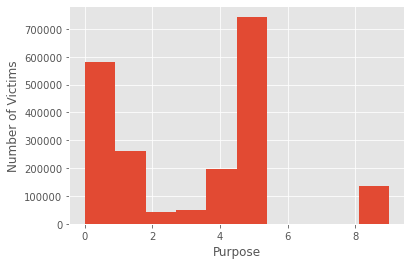

In [79]:
cleaned_dataset.purpose.hist()
plt.ylabel('Number of Victims')
plt.xlabel('Purpose')
plt.show()

One option to simplify and limit the number of classes would be to reclassify the 0 values with 9 - Others. We can check that the distribution of severity is similar for both classes to confirm this modification.

In [80]:
# Compute and display the cross matrix for the feature purpose and the severity
x = cleaned_dataset['purpose']
y = cleaned_dataset['upd_sev_2']

cross_mat = cross_matrix(x,y).sort_values('total',ascending=False).head(10)
cross_mat.loc[[0,9],:]

upd_sev_2,1,2,total,Perc. Sev. 1,Perc. Sev. 2
purpose,,,,,
0,446761,132731,579492,77.1,22.9
9,107001,30536,137537,77.8,22.2


Since they are similar, we can replace the 0 values as well as the remaining missing values with 9.

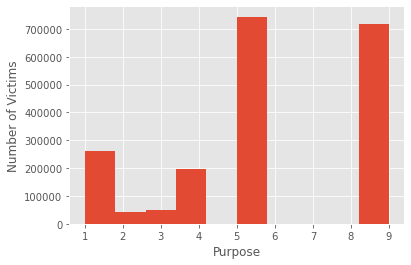

In [81]:
cleaned_dataset['purpose'].replace({0:9},inplace=True)
cleaned_dataset['purpose'].fillna(9,inplace=True)
cleaned_dataset['purpose'].hist()
plt.ylabel('Number of Victims')
plt.xlabel('Purpose')
plt.show()

We will wait for the features selection to drop any remaining rows with na values (since some of the columns we are going to drop have na values, it might limit the number of rows we will have to drop).

In [82]:
# Save dataset
cleaned_dataset.to_csv('Datasets/Aggregated Data/cleaned_dataset.csv',index=False)

### 3.2.4. Select Features

In [83]:
# Import dataset
selection_dataset = pd.read_csv('Datasets/Aggregated Data/cleaned_dataset.csv')
#selection_dataset = cleaned_dataset.copy()

#### Remove non relevant attributes

First, and following our analysis in the previous section, we can select the attributes to drop because we consider they will not be significant / relevant to predict the severity of a future accident:
- acc_ID,
- veh_ID,
- date,
- year,
- flow_dir,
- user_num,
- med_strip.

In [84]:
# Drop the non relevant attributes
selection_dataset.drop(columns=['acc_ID','veh_ID','date','year','flow_dir','user_num','med_strip'],inplace=True)

# Display the dataframe information to check
selection_dataset.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011542 entries, 0 to 2011541
Data columns (total 45 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   place_in_veh          2011542 non-null  float64
 1   user_type             2011542 non-null  int64  
 2   severity              2011542 non-null  int64  
 3   sex                   2011542 non-null  int64  
 4   purpose               2011542 non-null  float64
 5   security              2010124 non-null  float64
 6   pedestrian_loc        2009832 non-null  float64
 7   pedestrian_action     2009726 non-null  float64
 8   pedestrian_situation  2009770 non-null  float64
 9   birth_year            2009160 non-null  float64
 10  veh_cat               2011520 non-null  float64
 11  fixed_obst            2010679 non-null  float64
 12  mobile_obst           2010810 non-null  float64
 13  impact                2011369 non-null  float64
 14  manoeuvre             2011269 non-

#### Analyse Correlation
Then, we can analyse the correlaction between the different features to see if some of them stand out significantly from the others.

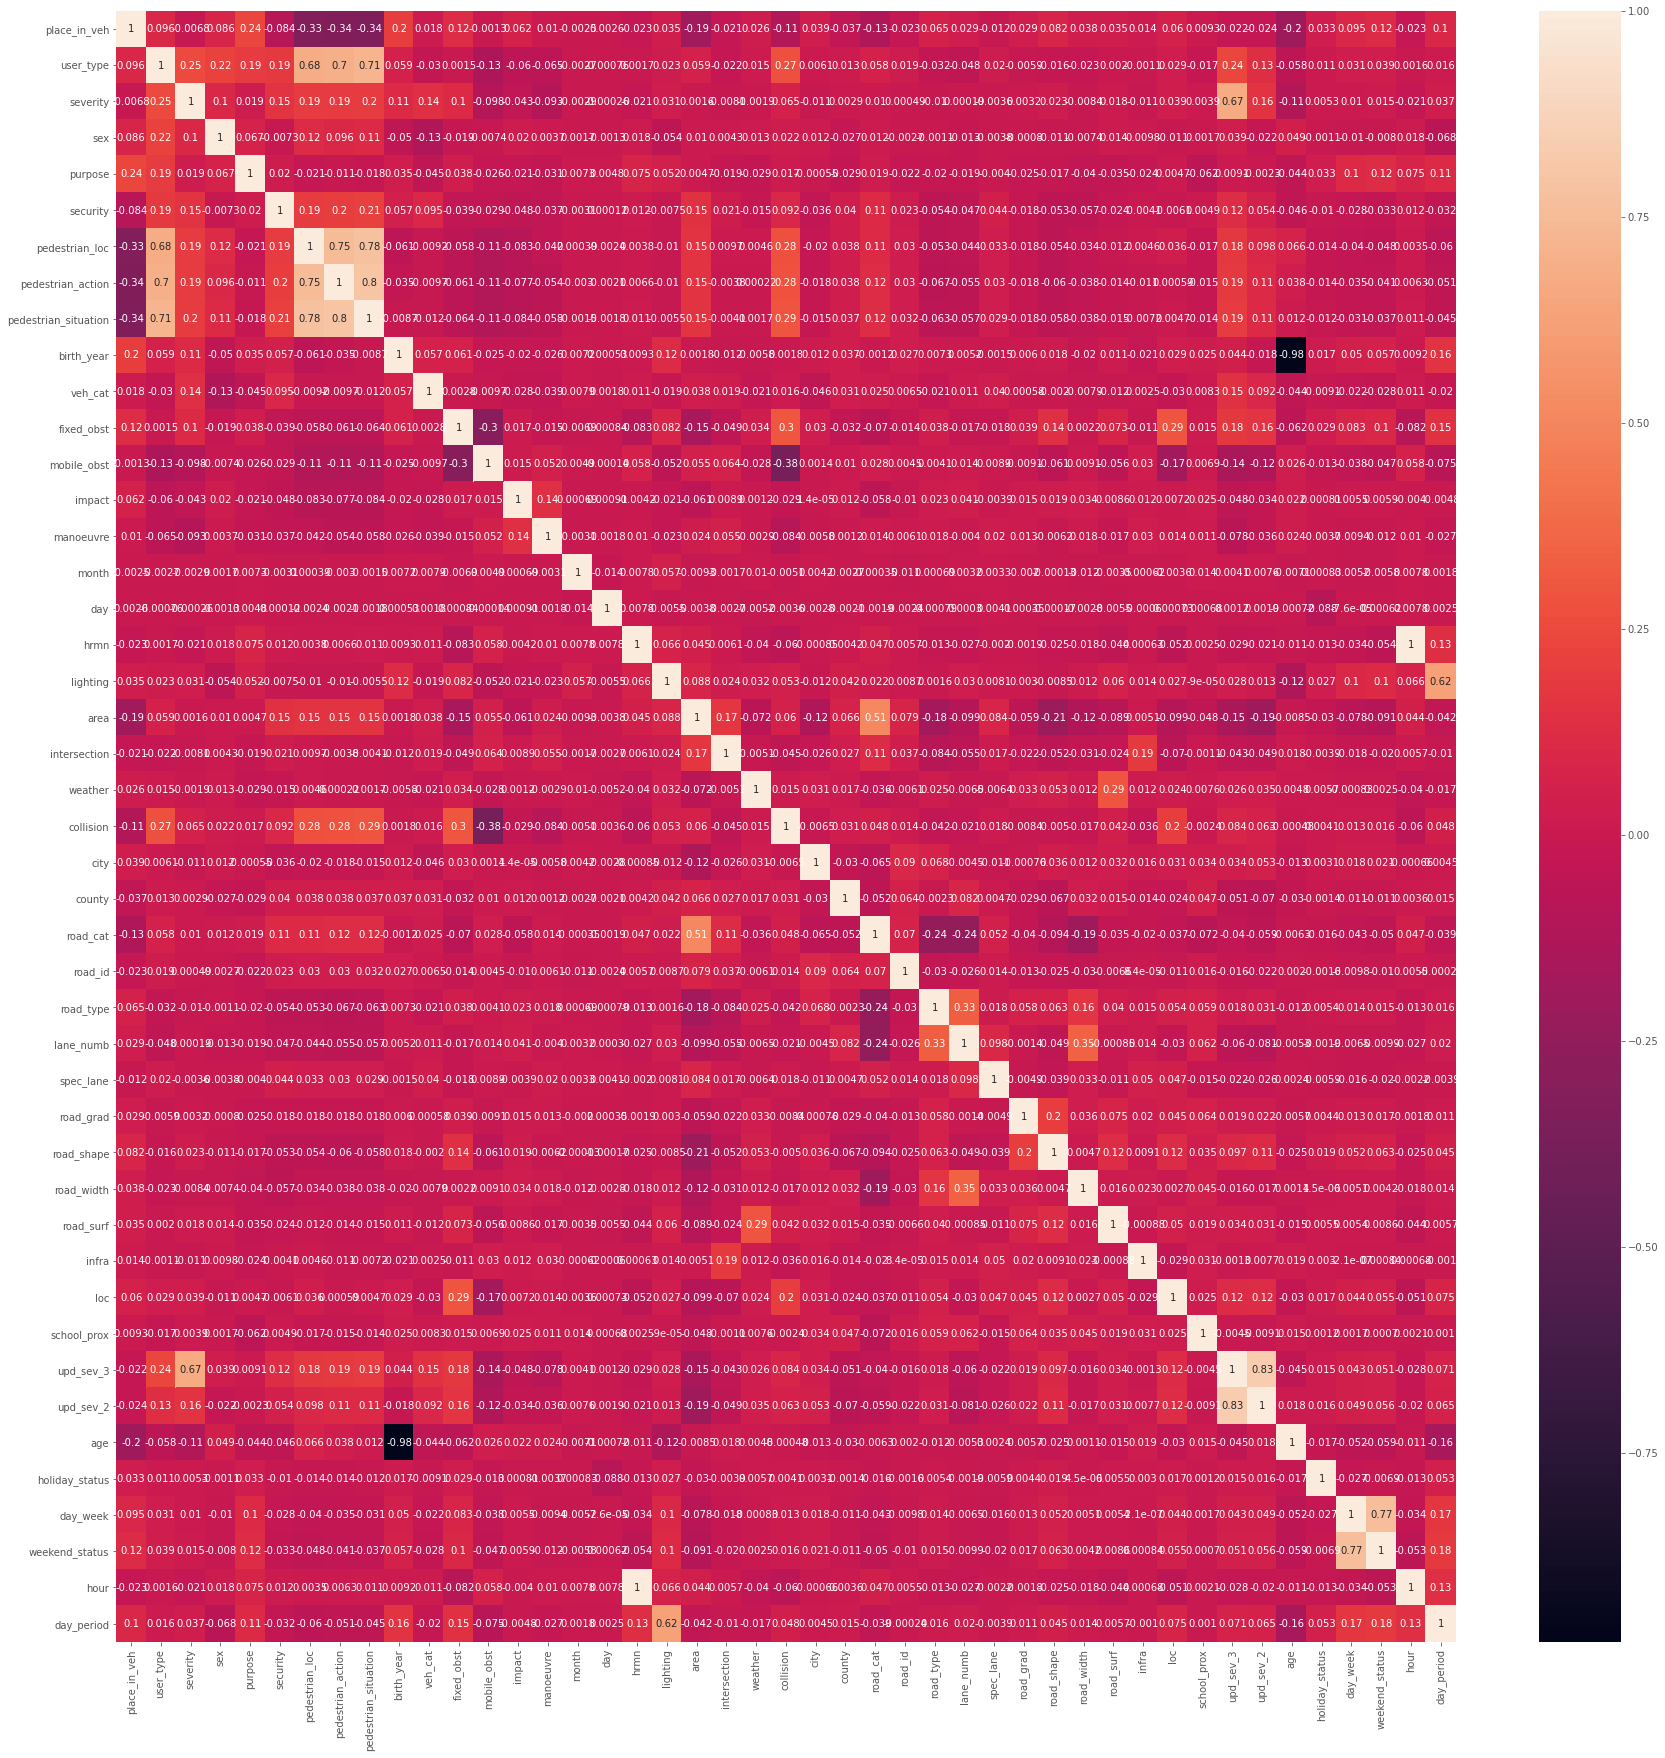

In [85]:
# Compute and display the correlation matrix
corr_matrix = selection_dataset.corr()

plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot = True)
plt.show()

The most significant correlation that we can notice are:
- For the different severity attributes (severity - upd_sev_2 - upd_sev_3) and some of the attributes we have added based on existing ones (birth_year - age), which is expected,
- Lighting and day_period, which is also understandable,
- To a lesser extend between area (urban / rural) and road_category with is also understandable.

We will take this information into account when modeling / testing our model to select the most appropriate features.

When we focus on the correlation between the updated severity and the other features, we can notice that none execept maybe the area stands out from the others.

In [86]:
# Show the correlation between the upd_sev_2 and the other columns
focus_sev = corr_matrix.upd_sev_2.to_frame()
focus_sev['Absolute Value'] = abs(focus_sev['upd_sev_2'])
focus_sev.sort_values('Absolute Value',ascending=False, inplace=True)

# Display the 15 first ones of the list
focus_sev.head(15)

,upd_sev_2,Absolute Value
upd_sev_2,1.000000,1.000000
upd_sev_3,0.831718,0.831718
area,-0.192041,0.192041
fixed_obst,0.159615,0.159615
severity,0.156667,0.156667
user_type,0.126557,0.126557
loc,0.124147,0.124147
mobile_obst,-0.115105,0.115105
road_shape,0.109346,0.109346
pedestrian_situation,0.108913,0.108913


Likewise, we will keep all these features and maybe some of them depending on their respective impact on our model.

#### Drop the na values
Now we remove the remaining rows with na values.

In [87]:
# Counts the number of na rows to drop
len(selection_dataset[selection_dataset.isnull().any(axis=1)])

38886

In [88]:
# Remove any na values
selection_dataset = selection_dataset.copy().dropna(axis=0)

# Check that there is no more missing values in our dataset
selection_dataset.isna().any().any()

False

In [89]:
# Save the dataset
selection_dataset.to_csv('Datasets/Aggregated Data/selection_dataset.csv',index=False)

## 3.3 Modeling <a name="modeling"></a>

### 3.3.1. Split the dataset

In [2]:
# Load the dataset
model_dataset = pd.read_csv('Datasets/Aggregated Data/selection_dataset.csv')

We are going:
1. First, to split our dataset in 2 dataframes, one for the selected features and one for the severity.
2. Then, we are going to split the dataset:
- Between the training and test sets,
- And for the training set, we will in one set that we will use to train the model, and another one that will be used as validation test to fine-tune the model hyperparameters.

Both splits are made with the 80/20 ratio.

We are going to write a function for this split so that we can use it more easily for the selection of the features and the tuning of our model.

In [3]:
from sklearn.model_selection import train_test_split

# Split the different training, validation and test sets
def split_dataset(model_dataset,features_to_drop, selected_severity):
    # Split the features and severity
    y = model_dataset[selected_severity]
    features = model_dataset.drop(columns=features_to_drop)
    
    # Split the dataset into the training set, the validation set and the test set
    X_training, X_test, y_training, y_test = train_test_split(features, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, random_state=1)

    # Print the number of rows and selected features of the dataset
    print(f'The dataset has {len(features)} rows and {len(features.columns)} features.')
    
    # Return the different datasets and the features
    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
# Select the severity we want to use
selected_severity = 'severity'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 42 features.


### 3.3.2. The Random Forest Model
We are going to use this model which is known to have good results for classification of structured categorical data while limiting the impact of overfitting that the Decision Tree model has. This model requires to have numerical data and does not need the data to be normalized or hot encoded. We can thus used the dataset as it is.

#### Train the model
Same as for the data split, we are going to use a function to train and get the scores of our model. 
This function will use the previous function we have just done to train the model. That will ease our tuning phase when we want to select different features.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import time

def train_test_model_rf (X_training, X_testing, y_training, y_testing,n=100, max_feat = 'auto'):
    # Create the model
    model = RandomForestClassifier(n_estimators=n, max_features = max_feat,random_state=1,n_jobs=-1)
    
    # Train the model
    model.fit(X_training,y_training)
    
    # Compute the accuracy of the model based on the 
    y_pred = model.predict(X_testing)
    acc = accuracy_score(y_testing,y_pred)
    
    # Compute the precision, recall and f1
    precision = precision_score(y_testing, y_pred,average='weighted')
    recall = recall_score(y_testing, y_pred,average='weighted')
    f1_sc = f1_score(y_testing, y_pred, average='weighted')
    
    # Compute the importances of the features
    importances = pd.DataFrame({'feature':X_training.columns,'importance':np.round(model.feature_importances_,5)})
    
    # Print the scores
    results = pd.DataFrame({'Indicators':['Accuracy','Precision','Recall','F1 Score'],
                           f'Random Forest - {n} trees':[round(acc,5),round(precision,5),round(recall,5),round(f1_sc,5)]})
    display(results)
    
    # Return the importances by descending order
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    return model, importances

We train a first model with a number of trees of 100 and the initial severity column.

In [6]:
%%time
# Train the model and print the scores
model_rf, importances_rf = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.66941
1,Precision,0.65596
2,Recall,0.66941
3,F1 Score,0.65505


CPU times: user 17min 46s, sys: 9.15 s, total: 17min 55s
Wall time: 4min 43s


Then, we train the same model with the 2 other severity columns we have added.

In [6]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 42 features.


In [10]:
%%time
# Train the model and print the scores
model_rf_2,importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.69123
1,Precision,0.68636
2,Recall,0.69123
3,F1 Score,0.68545


CPU times: user 18min 50s, sys: 5.64 s, total: 18min 56s
Wall time: 4min 58s


In [8]:
# Select the severity we want to use
selected_severity = 'upd_sev_3'

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 42 features.


In [10]:
%%time
# Train the model and print the scores
model_rf_3, importances_rf_3 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.69123
1,Precision,0.68636
2,Recall,0.69123
3,F1 Score,0.68545


CPU times: user 18min 22s, sys: 7.43 s, total: 18min 30s
Wall time: 4min 50s


#### Validate the classification and features selection
From these first modelings, we can see that the severity with only 2 classes is the best performing by a very significant margin.

Since having these 2 levels also makes sense regarding our goal to predict the severity for our potential "customers / stakeholders" (government, institutions, hospitals, healthcare systems...), we will select this classification.

Then, we can have a look at the most important features for the model and decide which ones we are going to keep:

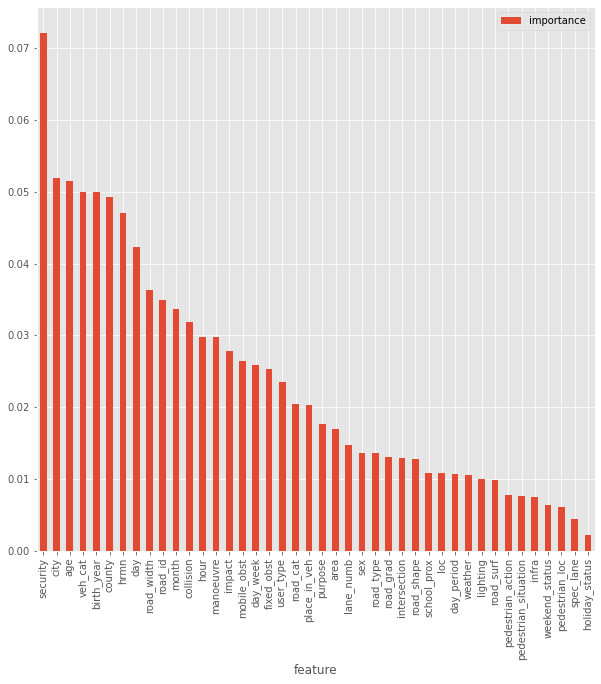

In [11]:
# Save the importances for the model with 2 classifications
importances_rf = importances_rf_2

# Display the features importance for the model
importances_rf.plot(kind='bar',figsize=(10,10))
plt.show()

Among the trade-offs we can do, we can notice that:
- The age we have added has slightly more weight than the initial birth_year, although being quite close. However, since it does not bring anything more in terms of information, we can remove it,
- The initial hrmn seems more appropriate than the 2 features we have added (hour and day_period), so we will drop them as well,
- The initial day seems to have more importance than the other attributes we have added. However, after several tests showing the holiday status and weekend status had some impact (although small), I decided to remove only the day of the week.

In [12]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','day_period','day_week']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 38 features.


In [8]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.82699
1,Precision,0.81521
2,Recall,0.82699
3,F1 Score,0.81292


CPU times: user 15min 22s, sys: 2.2 s, total: 15min 24s
Wall time: 4min


With the first selection of features, we managed to slightly improve the scores and reduce the wall time. 

However, we are still using a significant number of features. We can try to limit our features to the 5 first ones by order of importance for our model and see how it impacts our prediction scores.

In [13]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_rf.index[0:5]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 5 features.


In [14]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.74601
1,Precision,0.72221
2,Recall,0.74601
3,F1 Score,0.73056


CPU times: user 10min 16s, sys: 4.69 s, total: 10min 20s
Wall time: 2min 45s


Then, we can test with the 10 first features:

In [19]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_rf.index[0:10]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 10 features.


In [20]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.80627
1,Precision,0.78923
2,Recall,0.80627
3,F1 Score,0.78830


CPU times: user 15min 3s, sys: 1.39 s, total: 15min 4s
Wall time: 3min 57s


With the 15 first features:

In [16]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_rf.index[0:15]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 15 features.


In [17]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.81507
1,Precision,0.80050
2,Recall,0.81507
3,F1 Score,0.79930


CPU times: user 14min 35s, sys: 1.76 s, total: 14min 37s
Wall time: 3min 49s


With the 20 first features:

In [22]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_rf.index[0:20]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 20 features.


In [23]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.82359
1,Precision,0.81111
2,Recall,0.82359
3,F1 Score,0.81005


CPU times: user 16min 56s, sys: 1.46 s, total: 16min 58s
Wall time: 4min 27s


With the 25 first features:

In [24]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_rf.index[0:25]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 25 features.


In [25]:
%%time
# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100)

,Indicators,Random Forest - 100 trees
0,Accuracy,0.82537
1,Precision,0.81324
2,Recall,0.82537
3,F1 Score,0.81173


CPU times: user 19min 37s, sys: 1.41 s, total: 19min 39s
Wall time: 5min 11s


So, depending on our goals as well as the number of information we have available to predict the severity of an accident, we can adapt the selection of our features to maximize the accuracy of our model. Considering the gain in performance from 5 to 10 features, we might recommend to start, if possible, with a model with 10 features. 

#### Validate the model hyperparameters

Considering the size of the dataset and the limit of my computer and (free) cloud platforms (IBM, Google Colab and  Kaggle) I was using, I could not implement a proper fine tuning of the model with the grid search function (error message).

However, we can try to make some test on the validation set by modifying one parameter at the time.

We can start with the maximum number of features that we can set to None.

In [29]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','day_period','day_week']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 38 features.


In [ ]:
%%time

# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=100, max_feat=None)

We actually get a lower scores with no maximum features: 0.82564 vs 0.82699 for the accuracy of the model.

Then, we can try to increase the number of trees.

In [27]:
%%time

# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=200)

,Indicators,Random Forest - 200 trees
0,Accuracy,0.82784
1,Precision,0.81624
2,Recall,0.82784
3,F1 Score,0.81395


CPU times: user 38min 17s, sys: 5.5 s, total: 38min 23s
Wall time: 10min 3s


In [28]:
%%time

# Train the model and print the scores
model_rf_2, importances_rf_2 = train_test_model_rf (X_train, X_val, y_train, y_val,n=300)

,Indicators,Random Forest - 300 trees
0,Accuracy,0.82814
1,Precision,0.81661
2,Recall,0.82814
3,F1 Score,0.81432


CPU times: user 53min 57s, sys: 10.4 s, total: 54min 7s
Wall time: 14min 7s


When looking at the difference in processing time vs the limited gain in accuracy, we can decide to keep the 200 trees parameter.

### 3.3.3. The XGBoost Model
Since the random forest model has shown some quite good results, we are going to try another model also based on decision tree and which has shown great performance on similar problem.

#### Train the model

In [31]:
import xgboost as xgb

def train_test_model_xgb (X_training, X_testing, y_training, y_testing,n=100):
    # Create the model
    model = xgb.XGBClassifier(n_estimators=n, random_state = 1)
    
    # Train the model
    model.fit(X_training,y_training)
    
    # Compute the accuracy of the model based on the 
    y_pred = model.predict(X_testing)
    acc = accuracy_score(y_testing,y_pred)
    
    # Compute the precision, recall and f1
    precision = precision_score(y_testing, y_pred,average='weighted')
    recall = recall_score(y_testing, y_pred,average='weighted')
    f1_sc = f1_score(y_testing, y_pred, average='weighted')
    
    # Compute the importances of the features
    importances = pd.DataFrame({'feature':X_training.columns,'importance':np.round(model.feature_importances_,5)})
    
    # Print the scores
    results = pd.DataFrame({'Indicators':['Accuracy','Precision','Recall','F1 Score'],
                           f'XGBoost - {n} trees':[round(acc,5),round(precision,5),round(recall,5),round(f1_sc,5)]})
    display(results)
    
    # Return the importances by descending order
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    return model, importances

We will start with the same numbe of trees: 100.

In [32]:
# Select the severity we want to use
selected_severity = 'severity'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

The dataset has 1972656 rows and 42 features.


In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_3'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

#### Validate the model features and classification

As we could expect, the severity with 2 classes performs better with this model as well.

In [ ]:
# Save the importances for the model with 2 classifications
importances_xgb = importances_xgb_2

# Display the features importance for the model
importances_xgb.plot(kind='bar',figsize=(10,10))
plt.show()

However, the relative importances of the features are significantly different.

If we consider the trade-offs we did for the Random Forrest:
- The age has significantly more weight than the initial birth_year, so we can remove the birth year as well.
- The day period seems to have much more importance than the initial hrmn and the hour, so we will drop them,
- Of the different features linked to the day, the dayweek seems to have more weight altough all of them are at the end of the list. However, after several tests, the model that kept the day and holiday status performed slightly better, thus I decided to remove only the weekend_status.

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','hrmn','weekend_status']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

As for the Random Forest, we can try now look at the impact of the reduction of the number of features on the performance.
First, we try with the 5 most important features.

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:5]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

Then, with the 10 most important features:

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:10]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

Then, with the 15 most important features:

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:15]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

Then, with the 20 most important features:

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:20]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

Last, with the 25 most important features:

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:25]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=100)

#### Validate the model hyperparameters

As well as for the Random Forest Model, I also made other tests by tuning some of the hyperparameters and managed as well to get some incremental improvement of the scores, but remained limited by my computer or cloud environments to implement a proper fine tuning of the model.

If we focus only on the number of trees, we can get first with 200 trees:

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','hrmn','weekend_status']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=200)

Then, with 300 trees:

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=300)

Considering this processing time is even lower than the Random Forest with a lower parameter of trees, we can keep it for our model.

Last, we can also try this parameter with a lower number of features to see if we get a similar level of accuracy (as we noticed with 200 trees and 25 most important features).

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = [x for x in list(model_dataset.columns) if x not in importances_xgb.index[0:25]]

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb_2 = train_test_model_xgb (X_train, X_val, y_train, y_val,n=300)

Considering the lower score we get with the 25 features, we will keep the model with 38 features for the validation.

# 4. Results <a name="results"></a>

Using the test sets, we get the following results:

For the evaluation, considering the trade-off performance / processing time, I set the following parameters:
- Features selection: all the features (38) for both models,
- 200 trees for the Random Forest and 300 for the XGBoost.


## 4.1 With the Random Forest Model

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','day_period','day_week']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_rf, importances_rf = train_test_model_rf (X_train, X_test, y_train, y_test,n=200)

## 4.2 With the XGBoost Classifier

In [ ]:
# Select the severity we want to use
selected_severity = 'upd_sev_2'
    
# Set the columns to drop from the dataset. That includes the severity columns and the features we want to drop.
features_to_drop = ['severity','upd_sev_2','upd_sev_3','birth_year','hour','hrmn','weekend_status']

# Split the different training, validation and test sets
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(model_dataset,features_to_drop,selected_severity)

In [ ]:
%%time
# Train the model and print the scores
model_xgb, importances_xgb = train_test_model_xgb (X_train, X_test, y_train, y_test,n=300)

As we could expect, the XGBoost Classifier offers slightly better performance both in terms of score and processing time.

# 5. Discussion <a name="discussion"></a>

The goal of this study was to build a model to predict the severity of an accident based on several features / criteria. 

With the reduction of the number of classes for our severity classification from 4 to 2, we managed to get a model that performed fairly well at predicting this severity while keeping some room for improvement. 

Although some of features appeared to have more importance than others for our models, the best performing model(s) were the one(s) including a significant number of features. As we already knew road accidents are generally the combination of several factors, we could realize that the importance of these factors was not always the same for the different algorithms.

Depending on the goal and use of this model, we know that we will not always have all the information available which might impact the accuracy of the prediction. For instance, an emergency service receiving the information of an accident to handle the potential victims will certainly not have the detail of the 38 features we selected after the preparation of the data. Fortunately, we saw that a more limited number of features (from 5 or 10) was already providing an accuracy or around 80%.

For anticipation purpose (government, local institutions willing to prevent such accidents, healthcare services trying to forecast the needs for medical services for certain periods of time and locations), we should be able to provide the model with more information and to reach a higher accuracy.

As mentioned above, we could have improved the performance of these models with a proper fine-tuning of the hyperparameters. Another alternative would have been to limit the dataset to maybe the last 10 or even 5 years, which may have may represent more relevant data (because focusing on the most recent years) while allowing to perform this tuning without compromising significantly the prediction accuracy.

Among the other improvements of our model, we could also consider to implement some clustering techniques on some features that had an important number of occurrences such as the location, days, time of the day,…

Although the models selected provided some pretty good scores in terms of performance, we could also try other classification models not relying on Decision Tree (such as Logistic Regression, Support Vector Machine….)

Beyond the choices I made for the feature selection and model tuning, it could have also been interesting to adapt the severity classification to include the number of victims involved in one single accident. This would have allowed us to give more weight on the most critical accidents involving several people.

Last but not least, our model was not including some factors which are often considered as quite if not very important in terms of impact on road accidents, including:
- Human factors such as alcohol / dugs consumption, vehicle speed vs maximum speed limit, use of mobile...
- Vehicle characteristics such as car type, power engine, age of the vehicle,…


# Conclusion <a name="conclusion"></a>

Based on a dataset of road accidents in France from 2005 to 2017, we have built a model to predict the severity of a road accident. This model could be used by government or local institutions to prevent such accidents or for hospitals or healthcare services to anticipate the needs for medical services. 

Using models based on Tree Decision models, we managed to reach 83.15% of accuracy while reducing the percentage of false positives / negatives to less than 18%. The best of the 2 models we tested was the XGBoost Classifier.

These results leave some room for improvements:
- When it comes to the data:
    - First, by adding human factors which are often considered as very important in terms of impact on road accidents, or vehicle characteristics,
    - Then, by including in the severity the weight of the number of victims per accident,
- Regarding the model:
- By performing a proper fine-tuning of the hyperparameters, which might require to limit the number of years of our dataset,
    - By implementing some clustering techniques to handle some features with an important number of unique values,
    - And maybe by testing other types of algorithms to ensure they do not provide better results.